In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

def generate_class_0(N):
    m = [0,0]
    C = [[2, 0],[0,1]]
    return np.random.multivariate_normal(m, C, N)

def generate_class_1(N):
    m_A = [-2,1]
    C_A = [[9.0/8, 7.0/8],[7.0/8, 9.0/8]]
    m_B = [3,2]
    C_B = [[2, 1],[1, 2]]
    
    pi_1 = 1.0/3
    
    x1 = np.zeros((N,2))
    for i in range(0, N):
        a = random.uniform(0, 1)
        if (a < pi_1):
            x1[i, :] = np.random.multivariate_normal(m_A, C_A, 1)
        else:
            x1[i, :] = np.random.multivariate_normal(m_B, C_B, 1)
    return x1

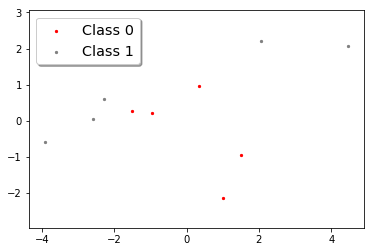

In [2]:
N = 10 # Number of samples

# Class 0, N/2 samples
x0 = generate_class_0(math.floor(N/2))
plt.scatter(x0[:, 0],x0[:, 1], label='Class 0', c='red', s=5)

# Class 1, N/2 samples
x1 = generate_class_1(math.floor(N/2))
plt.scatter(x1[:, 0],x1[:, 1], label='Class 1', c='grey', s=5)

legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.axis('equal')
plt.show()

In [3]:
x_train = np.concatenate([x0, x1])
y = np.append(np.zeros(int(N/2)), np.ones(int(N/2)))

# Shuffle the data
ind_perm = np.random.permutation(len(y))
x_train = x_train[ind_perm, :]
y = y[ind_perm]

# 1) SVM

In [4]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train, y)

# Classify class 0 as class -1
y[y == 0] = -1

# Use external implementation of the SMO algorithm
# http://jonchar.net/notebooks/SVM/
from SVM import SMOModel, gaussian_kernel, decision_function, train, plot_decision_boundary

# Set model parameters and initial values
C = 1.0
m = len(x_train)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(x_train, y, C, gaussian_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

## 1.1) Plot of the decision boundaries, and display of the support vectors

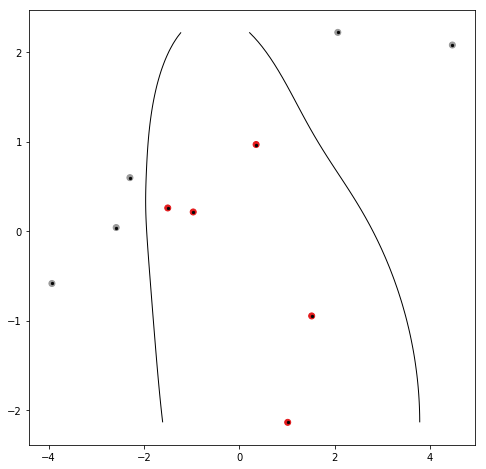

In [5]:
output = train(model)
fig, ax = plt.subplots(figsize=(8,8))
grid, ax = plot_decision_boundary(output, ax)

The plot above shows the two classes (class 0 in red, and class 1 in grey), with the decision boundary. Points that also have a black dot are support vectors.

In [6]:
# Support vectors have non-zero alphas
mask = model.alphas != 0.0
frac_support_vectors = len(model.X[:,0][mask]) / len(model.X[:,0])

print("Fraction of training data points that are support vectors:")
print(frac_support_vectors)

Fraction of training data points that are support vectors:
1.0


## 1.2) Comparison of misclassification performance between SVM and kernelized logistic regression

In [7]:
classified_points = [decision_function(model.alphas, model.y,
                               model.kernel, model.X,
                               np.array(x), model.b) for x in model.X]
classified_points = np.array(classified_points).reshape(len(model.X[:, 0]), 1)
        
classified_points[classified_points < 0] = -1
classified_points[classified_points > 0] = 1

misclassification_error = 0
for i in range(len(y)):
    if classified_points[i] != y[i]:
        misclassification_error += 1        

print("Probability of incorrect classification:")
print(misclassification_error / len(y))

Probability of incorrect classification:
0.0


For kernelized regression we got a misclassification error probability of about ~0.15, which is very similar to that of the error probability for SVM above.

# 2) Adaboost

*AdaBoost (Freund & Schapire 1997)*

In [8]:
# TODO: Remove this cell
N = 10 # Number of samples

# Class 0, N/2 samples
x0 = generate_class_0(math.floor(N/2))
# Class 1, N/2 samples
x1 = generate_class_1(math.floor(N/2))

x_train = np.concatenate([x0, x1])
y = np.append(np.zeros(int(N/2)), np.ones(int(N/2)))

# Shuffle the data
ind_perm = np.random.permutation(len(y))
x_train = x_train[ind_perm, :]
y = y[ind_perm]

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

M = 5

# 1. Initialize the observation weights
w = np.ones(N) / N
prediction = np.zeros(N)
alpha = np.zeros(M)

C = np.zeros((N,2))

# 2.
for m in range(M):
    # a) 
    T = DecisionTreeClassifier(max_depth=1, random_state=1)
    T.fit(x_train, y, sample_weight=w)
    prediction_m = T.predict(x_train)
    #T.predict(x_grid)
    
    # b)
    I = [int(x) for x in (prediction_m != y)]
    err_m = (np.dot(w, I)) / np.sum(w)
    
    I_new = [x if x==1 else -1 for x in I] # Update weights with +1/-1
    
    # c)
    alpha_m = np.log( (1 - err_m) / float(err_m) )
    alpha[m] = alpha_m
    
    # d)
    w = np.multiply(w, np.exp([alpha_m * float(x) for x in I]))
    
    # e)
    w = w / np.sum(w)
    
    # 3. Output
    # Compute one-hot encoding
    prediction_m_onehot = np.zeros((N, 2))
    for i in range(N):
        prediction_m_onehot[i, int(prediction_m[i])] = 1
    
    C += alpha[m] * prediction_m_onehot
    
C = np.argmax(C, axis=1).astype(np.float32)

print(C)
print(y)

[0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
[1. 1. 1. 0. 0. 1. 0. 0. 0. 1.]


In [ ]:
# TODO: REMOVE
"""
C = np.zeros(n)
for i in range(N):
    val = np.zeros(2)
    for k in [0, 1]:
        I = [int(x) for x in (prediction_i == k)]
        val[k] = np.sum(alpha_m * float(x) for x in I)
    C[i] = np.argmax(val)
"""

In [ ]:
clf = DecisionTreeClassifier(max_depth=1, random_state=1)
pred_train = np.zeros(n)

for i in range(M):
    # Fit a classifier with the specific weights
    clf.fit(x_train, y, sample_weight = w)
    pred_train_i = clf.predict(x_train)
    # Indicator function
    miss = [int(x) for x in (pred_train_i != y)]
    # Equivalent with 1/-1 to update weights
    miss2 = [x if x==1 else -1 for x in miss]
    # Error
    err_m = np.dot(w,miss) / sum(w)
    # Alpha
    alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
    # New weights
    w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
    # Add to prediction
    pred_train = [sum(x) for x in zip(pred_train, 
                                      [x * alpha_m for x in pred_train_i])]
    
print(pred_train)

## SK-learn implementation

In [ ]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=5)

bdt.fit(x_train, y)

plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(x_train[idx, 0], x_train[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

## 2.1) Plot of the decision boundaries